In [316]:
import numpy as np
from scipy.integrate import odeint
import scipy.stats as sps

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from scipy.optimize import curve_fit
from matplotlib.gridspec import GridSpec

In [317]:
def PlotStyle(Axes,Title):
    
    Axes.spines['top'].set_visible(False)
    Axes.spines['right'].set_visible(False)
    Axes.spines['bottom'].set_visible(True)
    Axes.spines['left'].set_visible(True)
    Axes.set_title(Title)

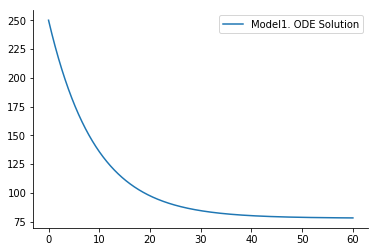

In [338]:
#Defining and solving the model

size = 60
p1 = -1.09/10
p2 = 8.5 
G0 = 250

T = np.linspace(0, size, size*60)

def model1(G, t):
    return p1*G + p2

G_data = odeint(model1, G0, T)

plt.figure(1)
plt.plot(T, G_data, label='Model1. ODE Solution')
ax=plt.gca()
ax.legend(loc=0)
PlotStyle(ax,'')

In [339]:
#Parameter estimation
def GeneralSolver(t, p1, p2, G0):
    localp1 = p1
    localp2 = p2
    localG0 = G0
    
    def ODEModel(G, t):
        return localp1*G + localp2
    
    sol = odeint(ODEModel, localG0, t)
    return sol[:,0]

def ODESolution(t, p1, p2):
    return GeneralSolver(t,p1,p2,G0)

def MakeNoisyData(Data, Noise):
    return [val+cal for val,cal in zip(Data,Noise)]


#t_vals = np.linspace(0,10)
t_vals = np.linspace(0, 10)
solution = ODESolution(t_vals, p1, p2)

WhiteNoise = [np.random.uniform(low=-1,high=1)/20 for val in solution]
WhiteSignal = MakeNoisyData(solution,WhiteNoise)


In [340]:
popt = curve_fit(ODESolution,t_vals,WhiteSignal)[0]
popt

array([-0.10899873,  8.50051168])

In [341]:
fitSolution=ODESolution(t_vals,popt[0], popt[1])

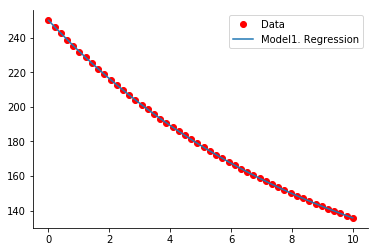

In [342]:
plt.figure(2)

plt.plot(t_vals,WhiteSignal,'ro',label='Data')
plt.plot(t_vals,fitSolution,label='Model1. Regression')
ax=plt.gca()
ax.legend(loc=0)
PlotStyle(ax,'')

####  This model is too simple for predicting the parameters in the x \in [0,60]. On a plot above x \in [0,2]

We have such a equation
$$\frac{dG}{dt}=p_1 G + p_2$$
And the solution is
$$G(t) = (p_3+\frac{p_2}{p_1}) e^{p_1t}-\frac{p_2}{p_1}$$

In [323]:
#Data size lenghts to test 
nums=[1000,500,100,50,25,10]

#Library of ODE solutions 
t_lib=[np.linspace(0,10,num=val) for val in nums]
sol_lib=[ODESolution(clib,p1,p2) for clib in t_lib]

#Library of simulated data 
noises=[[np.random.uniform(low=-1,high=1)/20 for val in sol] for sol in sol_lib]
signal=[MakeNoisyData(sol,nos) for sol,nos in zip(sol_lib,noises)]

#Parameter estimation an performance evaluation 
params=[curve_fit(ODESolution,times,signals)[0] for times,signals in zip(t_lib,signal)] 
solutions=[ODESolution(times,param[0],param[1]) for times,param in zip(t_lib,params)]

paramError=[[abs(val[0]-p1)/p1, abs(val[1]-p2)/p2] for val in params]


In [324]:
paramError

[[-9.987208609227023e-05, 0.0002474534939282043],
 [-0.0001411053917418532, 0.0003795892998401401],
 [-0.0008094954204916435, 0.002135695743568742],
 [-0.0007602836540800981, 0.0017455873930663469],
 [-0.0001189816417830448, 0.00012614862552846475],
 [-0.0008311461599329748, 0.0020410318900305627]]

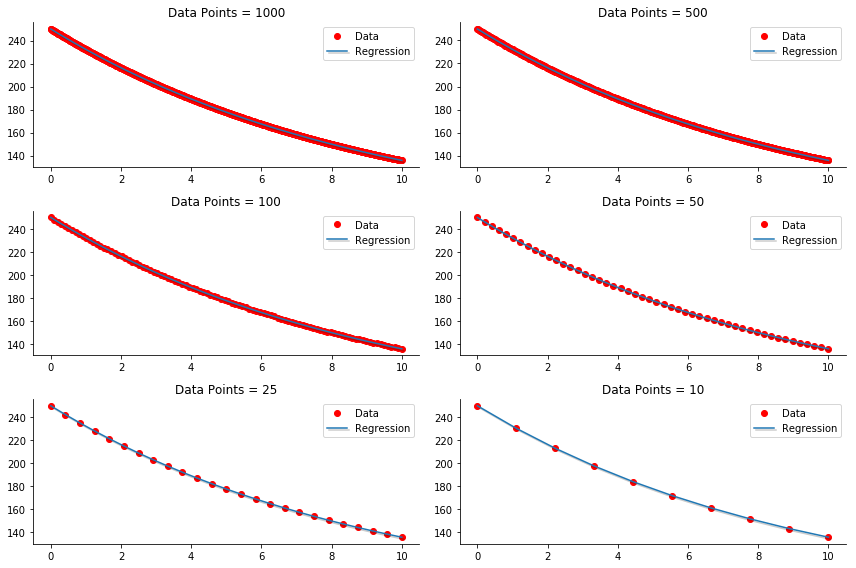

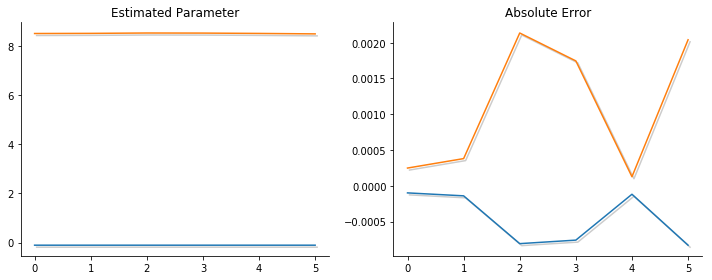

In [325]:
axs=[(i,j) for i in range(3) for j in range(2)]
fig0,axes=plt.subplots(3,2,figsize=(12,8))

for k in range(len(nums)):
    
    axes[axs[k]].plot(t_lib[k],signal[k],'or',label='Data')
    axes[axs[k]].plot(t_lib[k],solutions[k],label='Regression',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
    axes[axs[k]].legend(loc=0)
    
    title='Data Points = '+str(len(signal[k]))
    
    PlotStyle(axes[axs[k]],title)

plt.tight_layout()

fig1,axs=plt.subplots(1,2,figsize=(10,4))

axs[0].plot(params,path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
PlotStyle(axs[0],'Estimated Parameter')

axs[1].plot(paramError,path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
PlotStyle(axs[1],'Absolute Error')

plt.tight_layout()

In [326]:
###############################################################################
#                   Data generation for residuals analysis  
###############################################################################

#ODE solution 
t_data=np.linspace(0,2)
sol=ODESolution(t_data,p1, p2)

#Generating noise data with mixed signals 
WhiteNoise=[np.random.uniform(low=-1,high=1)/20 for val in sol]
PeriodicNoise=[np.random.uniform(low=-1,high=1)/30+np.sin(val/np.pi)/30 for val in range(len(t_data))]
LinearNoise=[np.random.uniform(low=-1,high=1)/30-0.04*(val/30) for val in range(len(t_data))]

In [327]:
###############################################################################
#                            Residuals analysis 
###############################################################################

WhiteSignal=MakeNoisyData(sol,WhiteNoise)
PeriodicSignal=MakeNoisyData(sol,PeriodicNoise)
LinearSignal=MakeNoisyData(sol,LinearNoise)

paramWhite=curve_fit(ODESolution,t_data,WhiteSignal)
paramPeriodic=curve_fit(ODESolution,t_data,PeriodicSignal)
paramLinear=curve_fit(ODESolution,t_data,LinearSignal)

fitSolutionWhite=ODESolution(t_data,paramWhite[0][0],paramWhite[0][1])
fitSolutionPeriodic=ODESolution(t_data,paramPeriodic[0][0],paramPeriodic[0][1])
fitSolutionLinear=ODESolution(t_data,paramLinear[0][0],paramLinear[0][1])

residualsWhite=[val-cal for val,cal in zip(WhiteSignal,fitSolutionWhite)]
residualsPeriodic=[val-cal for val,cal in zip(PeriodicSignal,fitSolutionPeriodic)]
residualsLinear=[val-cal for val,cal in zip(LinearSignal,fitSolutionLinear)]


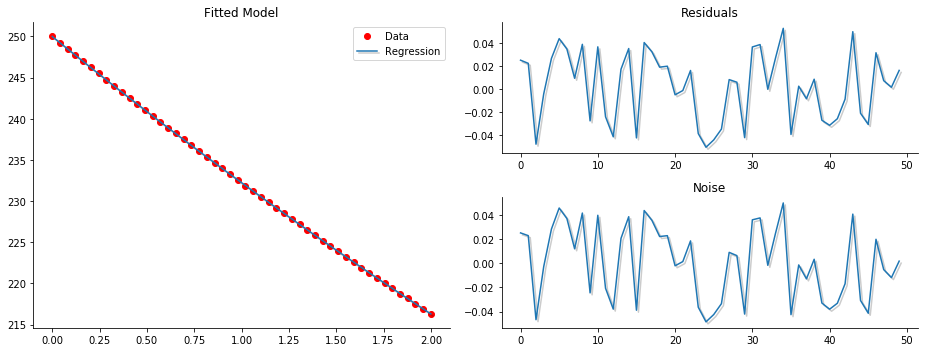

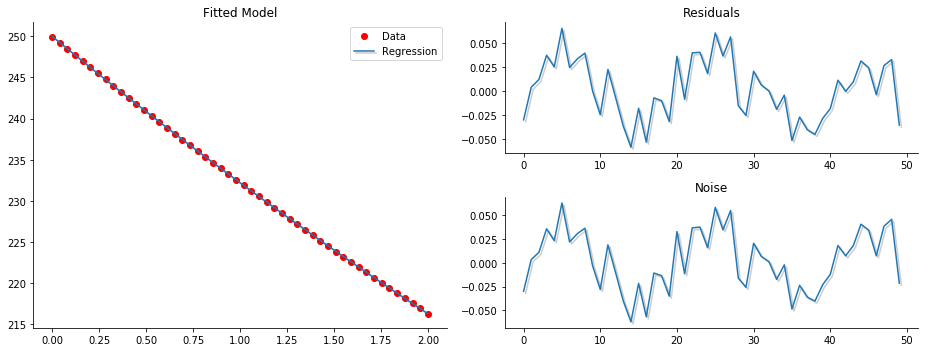

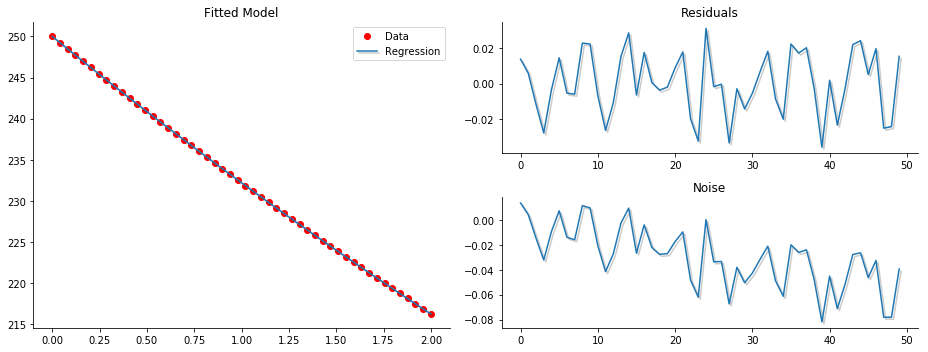

In [328]:
###############################################################################
#                    Residual analysis visualization 
###############################################################################

def ResidualsPlot(Figure,Time,Signal,FitSolution,Residuals,Noise):
    
    cFig=Figure
    gridSp=GridSpec(2,2)
    
    ax1=cFig.add_subplot(gridSp[:,0])
    ax2=cFig.add_subplot(gridSp[0,1])
    ax3=cFig.add_subplot(gridSp[1,1])
    
    ax1.plot(Time,Signal,'ro',label='Data')
    ax1.plot(Time,FitSolution,label='Regression',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
    ax1.legend(loc=0)
    PlotStyle(ax1,'Fitted Model')
    
    ax2.plot(Residuals,path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
    PlotStyle(ax2,'Residuals')
    
    ax3.plot(Noise,path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
    PlotStyle(ax3,'Noise')
    
    plt.tight_layout()

    
fig2=plt.figure(5,figsize=(13,5))

ResidualsPlot(fig2,t_data,WhiteSignal,fitSolutionWhite,residualsWhite,WhiteNoise)

fig3=plt.figure(6,figsize=(13,5))

ResidualsPlot(fig3,t_data,PeriodicSignal,fitSolutionPeriodic,residualsPeriodic,PeriodicNoise)

fig4=plt.figure(7,figsize=(13,5))

ResidualsPlot(fig4,t_data,LinearSignal,fitSolutionLinear,residualsLinear,LinearNoise)


In [314]:
def Model3(p1,p2,p3,p4,Variables):
    Equation1= p1 * Variables[0] + p2 * Variables[1] + p3
    Equation2= Variables[0] + p4 * Variables[1]
    return [Equation1,Equation2]

#Integration time
SolverTime=np.linspace(0,60,num=200)

#Parameters of the model 
p1 = 1.87 / 100
p2 = -1.25 / 100
p3 = 9.21
p4 = -1.97 / 10

#Initial conditions 
Int=np.array([250,10])  

#Model Solution 
def ODEModel(InitialConditions,t):
    return Model3(p1,p2,p3,p4, InitialConditions)

Solution=odeint(ODEModel,Int,SolverTime)

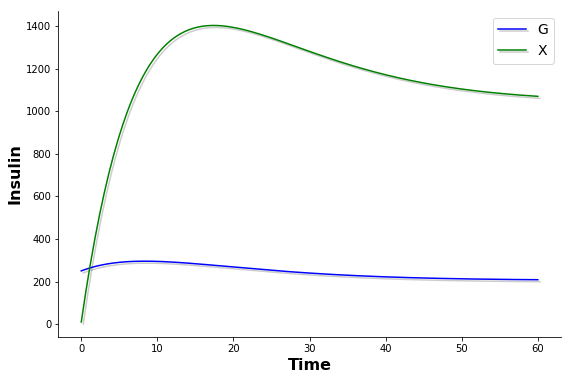

In [315]:
plt.figure(1,figsize=(9,6))

plt.plot(SolverTime,Solution[:,0],'b-',label='G',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(SolverTime,Solution[:,1],'g-',label='X',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time',fontsize=16,fontweight='bold')
plt.ylabel('Insulin',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)

ax=plt.gca()
PlotStyle(ax,'')